# ボートレース着順予想のための主成分分析

対象：Programs、Previews、Resultsの3つのデータソースを組み合わせて、着順（目的変数）を予想するための特徴量を選定

## 目的
1. Programs、Previews、Resultsからデータを読み込みマージする
2. 各データソースから候補特徴量を抽出する
3. PCAを実行して次元削減し、重要な特徴量を特定する
4. 下流の予想モデルで使用する特徴量を決定する

## セットアップとデータローディング

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Determine repository root
cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent

# Set date to analyze
year = '2016'
month = '01'
day = '15'

programs_path = repo_root / 'data' / 'programs' / year / month / f'{day}.csv'
previews_path = repo_root / 'data' / 'previews' / year / month / f'{day}.csv'
results_path = repo_root / 'data' / 'results' / year / month / f'{day}.csv'

print(f"Programs: {programs_path.exists()}")
print(f"Previews: {previews_path.exists()}")
print(f"Results: {results_path.exists()}")

Programs: True
Previews: True
Results: True


In [3]:
# Load data
programs = pd.read_csv(programs_path)
previews = pd.read_csv(previews_path)
results = pd.read_csv(results_path)

print(f"Programs shape: {programs.shape}")
print(f"Previews shape: {previews.shape}")
print(f"Results shape: {results.shape}")

print(f"\nPrograms columns: {list(programs.columns[:10])}...")
print(f"Previews columns: {list(previews.columns[:10])}...")
print(f"Results columns: {list(results.columns[:10])}...")

Programs shape: (132, 177)
Previews shape: (72, 53)
Results shape: (132, 100)

Programs columns: ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回', 'レース名', '距離(m)', '電話投票締切予定', '1枠_艇番']...
Previews columns: ['レースコード', 'タイトル', 'レース日', 'レース場', 'レース回', '風速(m)', '風向', '波の高さ(cm)', '天候', '気温(℃)']...
Results columns: ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回', 'レース名', '距離(m)', '天候', '風向']...


## 特徴量エンジニアリング

### データ構造
- Programs: 6艇の情報が列として存在（1枠_*, 2枠_*, ..., 6枠_*）
- Previews: 6艇の情報が列として存在（艇1_*, 艇2_*, ..., 艇6_*）
- Results: 6着分の情報が列として存在（1着_*, 2着_*, ..., 6着_*）

### 戦略
1. 各データソースをlong形式に変形（1行 = 1艇）
2. レースコードと艇番でマージ
3. Programs、Previews、Resultsから特徴量を抽出
4. 派生特徴量を計算（比率、ランク、相互作用項など）

In [4]:
# Reshape Programs data (1枠～6枠)
race_id_cols = ['レースコード', 'レース日', 'レース場', 'レース回']

program_frames = []
for frame_num in range(1, 7):  # 1枠～6枠
    frame_prefix = f'{frame_num}枠_'
    
    # Identify columns for this frame
    frame_cols = [col for col in programs.columns if col.startswith(frame_prefix)]
    
    if frame_cols:
        tmp = programs[race_id_cols + frame_cols].copy()
        
        # Rename columns to remove frame prefix
        rename_map = {col: col[len(frame_prefix):] for col in frame_cols}
        tmp = tmp.rename(columns=rename_map)
        
        tmp['枠'] = frame_num
        program_frames.append(tmp)

programs_long = pd.concat(program_frames, ignore_index=True)
print(f"Programs (long format): {programs_long.shape}")
print(f"Columns: {list(programs_long.columns[:15])}...")

Programs (long format): (792, 33)
Columns: ['レースコード', 'レース日', 'レース場', 'レース回', '艇番', '登録番号', '選手名', '年齢', '支部', '体重', '級別', '全国勝率', '全国2連対率', '当地勝率', '当地2連対率']...


In [5]:
# Reshape Previews data (艇1～艇6)
race_id_cols = ['レースコード', 'レース日', 'レース場', 'レース回']

preview_frames = []
for boat_num in range(1, 7):  # 艇1～艇6
    boat_prefix = f'艇{boat_num}_'
    
    # Identify columns for this boat
    boat_cols = [col for col in previews.columns if col.startswith(boat_prefix)]
    
    if boat_cols:
        tmp = previews[race_id_cols + boat_cols].copy()
        
        # Rename columns to remove boat prefix
        rename_map = {col: col[len(boat_prefix):] for col in boat_cols}
        tmp = tmp.rename(columns=rename_map)
        
        # Get environment info (only from boat 1 to avoid duplication)
        # NOTE: Wave height (波の高さ(cm)) is excluded from environment data
        if boat_num == 1:
            env_cols = ['風速(m)', '風向', '天候', '気温(℃)', '水温(℃)']
            tmp = pd.concat([
                tmp,
                previews[[col for col in env_cols if col in previews.columns]]
            ], axis=1)
        else:
            # For other boats, just copy environment from boat 1
            env_cols = ['風速(m)', '風向', '天候', '気温(℃)', '水温(℃)']
            env_data = previews[[col for col in env_cols if col in previews.columns]].iloc[tmp.index]
            for col in env_data.columns:
                if col not in tmp.columns:
                    tmp[col] = env_data[col].values
        
        tmp['艇'] = boat_num
        preview_frames.append(tmp)

previews_long = pd.concat(preview_frames, ignore_index=True)
print(f"Previews (long format): {previews_long.shape}")
print(f"Columns: {list(previews_long.columns[:15])}...")

Previews (long format): (432, 17)
Columns: ['レースコード', 'レース日', 'レース場', 'レース回', '艇番', 'コース', '体重(kg)', '体重調整(kg)', '展示タイム', 'チルト調整', 'スタート展示', '風速(m)', '風向', '天候', '気温(℃)']...


In [6]:
# Reshape Results data (1着～6着)
result_frames = []
for place in range(1, 7):  # 1着～6着
    place_prefix = f'{place}着_'
    
    # Identify columns for this place
    place_cols = [col for col in results.columns if col.startswith(place_prefix)]
    
    if place_cols:
        tmp = results[['レースコード'] + place_cols].copy()
        
        # Rename columns to remove place prefix
        rename_map = {col: col[len(place_prefix):] for col in place_cols}
        tmp = tmp.rename(columns=rename_map)
        
        tmp['着順'] = place
        result_frames.append(tmp)

results_long = pd.concat(result_frames, ignore_index=True)
results_long = results_long.dropna(subset=['艇番'])

print(f"Results (long format): {results_long.shape}")
print(f"Columns: {list(results_long.columns[:15])}...")

Results (long format): (778, 11)
Columns: ['レースコード', '着順', '艇番', '登録番号', '選手名', 'モーター番号', 'ボート番号', '展示タイム', '進入コース', 'スタートタイミング', 'レースタイム']...


## データソースのマージ

In [7]:
# Merge programs and previews
# Key: レースコード and 艇番

# Note: レース場 has different dtypes (int64 in previews, object in programs)
# Solution: Only merge on レースコード (it uniquely identifies the race)
# Then filter by matching boat numbers

# Prepare for merge
programs_long = programs_long.rename(columns={'艇番': '艇番_prog'}) if '艇番' in programs_long.columns else programs_long

# Drop unnecessary race-id columns from programs before merge to avoid dtype conflicts
programs_long_merge = programs_long.drop(columns=['レース日', 'レース場', 'レース回'], errors='ignore')

# Merge on レースコード only (uniquely identifies the race)
merged = previews_long.merge(
    programs_long_merge,
    on='レースコード',
    how='left',
    suffixes=('_preview', '_program')
)

# Filter: match on boat number (艇番 in previews)
if '艇番' in merged.columns and '艇番_prog' in merged.columns:
    # Keep only rows where boat numbers match
    merged = merged[merged['艇番'] == merged['艇番_prog']].copy()
    # Drop the duplicate boat number column
    merged = merged.drop(columns=['艇番_prog'], errors='ignore')

print(f"Merged programs + previews: {merged.shape}")
print(f"Sample columns: {list(merged.columns[:20])}...")
print(f"Data types check - レース場: {merged['レース場'].dtype if 'レース場' in merged.columns else 'N/A'}")

Merged programs + previews: (432, 45)
Sample columns: ['レースコード', 'レース日', 'レース場', 'レース回', '艇番', 'コース', '体重(kg)', '体重調整(kg)', '展示タイム', 'チルト調整', 'スタート展示', '風速(m)', '風向', '天候', '気温(℃)', '水温(℃)', '艇', '登録番号', '選手名', '年齢']...
Data types check - レース場: int64


In [8]:
# Merge with results
# Results has boat number in '艇番' column

# Merge on レースコード and 艇番
final_data = merged.merge(
    results_long[['レースコード', '艇番', '着順']],
    on=['レースコード', '艇番'],
    how='left'
)

print(f"Final merged data: {final_data.shape}")
print(f"Missing finish positions: {final_data['着順'].isna().sum()}")

# Remove rows without finish position
final_data = final_data.dropna(subset=['着順']).copy()
print(f"Final data (after removing NaN): {final_data.shape}")

# Verify merge quality
print(f"\nData integrity check:")
print(f"  Unique races: {final_data['レースコード'].nunique()}")
print(f"  Finish positions distribution:")
print(final_data['着順'].value_counts().sort_index())

Final merged data: (432, 46)
Missing finish positions: 12
Final data (after removing NaN): (420, 46)

Data integrity check:
  Unique races: 72
  Finish positions distribution:
着順
1.0    72
2.0    72
3.0    72
4.0    71
5.0    68
6.0    65
Name: count, dtype: int64


## 各データソースからの候補特徴量

In [9]:
# Feature name mapping (Japanese -> English for visualization)
feature_name_map = {
    '全国勝率': 'National Win Rate',
    '全国2連対率': 'National Top-2 Rate',
    '当地勝率': 'Local Win Rate',
    '当地2連対率': 'Local Top-2 Rate',
    'モーター2連対率': 'Motor Top-2 Rate',
    'ボート2連対率': 'Boat Top-2 Rate',
    '体重(kg)': 'Weight (kg)',
    '体重調整(kg)': 'Weight Adjustment (kg)',
    '展示タイム': 'Showcase Time (s)',
    'チルト調整': 'Tilt Adjustment',
    'スタート展示': 'Start Showcase (s)',
    '風速(m)': 'Wind Speed (m/s)',
    '風向': 'Wind Direction',
    '気温(℃)': 'Temperature (°C)',
    '水温(℃)': 'Water Temperature (°C)',
    'コース': 'Course',
    '着順': 'Finish Position'
}

# From Programs: Player stats
program_features = [
    '全国勝率', '全国2連対率',           # National stats
    '当地勝率', '当地2連対率',         # Local stats
    'モーター2連対率', 'ボート2連対率' # Equipment stats
]

# From Previews: Race-day conditions and boat performance
# NOTE: 波の高さ(cm) is excluded from this analysis
preview_features = [
    '体重(kg)', '体重調整(kg)',         # Weight info
    '展示タイム',                       # Showcase time
    'チルト調整', 'スタート展示',       # Engine and start adjustments
    '風速(m)', '風向',                 # Environmental conditions (wave height excluded)
    '気温(℃)', '水温(℃)',             # Temperature
    'コース'                            # Starting course
]

# Target variable
target = '着順'

print("Program features:", program_features)
print("\nPreview features:", preview_features)
print(f"\nTarget: {target}")
print("\nNote: Wave height (波の高さ(cm)) has been excluded from the analysis")

Program features: ['全国勝率', '全国2連対率', '当地勝率', '当地2連対率', 'モーター2連対率', 'ボート2連対率']

Preview features: ['体重(kg)', '体重調整(kg)', '展示タイム', 'チルト調整', 'スタート展示', '風速(m)', '風向', '気温(℃)', '水温(℃)', 'コース']

Target: 着順

Note: Wave height (波の高さ(cm)) has been excluded from the analysis


In [10]:
# Check availability of features in final_data
print("Available features:")
for feat in program_features + preview_features:
    if feat in final_data.columns:
        non_null = final_data[feat].notna().sum()
        print(f"  {feat}: {non_null}/{len(final_data)} ({100*non_null/len(final_data):.1f}%)")
    else:
        print(f"  {feat}: NOT FOUND")

Available features:
  全国勝率: 420/420 (100.0%)
  全国2連対率: 415/420 (98.8%)
  当地勝率: 394/420 (93.8%)
  当地2連対率: 386/420 (91.9%)
  モーター2連対率: 350/420 (83.3%)
  ボート2連対率: 420/420 (100.0%)
  体重(kg): 420/420 (100.0%)
  体重調整(kg): 420/420 (100.0%)
  展示タイム: 420/420 (100.0%)
  チルト調整: 420/420 (100.0%)
  スタート展示: 420/420 (100.0%)
  風速(m): 420/420 (100.0%)
  風向: 348/420 (82.9%)
  気温(℃): 420/420 (100.0%)
  水温(℃): 420/420 (100.0%)
  コース: 420/420 (100.0%)


## PCAのための特徴量準備

In [11]:
# Select available features
available_features = [
    feat for feat in (program_features + preview_features)
    if feat in final_data.columns
]

print(f"Using {len(available_features)} features:")
for feat in available_features:
    print(f"  - {feat}")

# Create feature matrix
X = final_data[available_features].copy()
y = final_data[target].copy()

print(f"\nFeature matrix shape before cleaning: {X.shape}")
print(f"Missing values per feature:")
print(X.isna().sum())

Using 16 features:
  - 全国勝率
  - 全国2連対率
  - 当地勝率
  - 当地2連対率
  - モーター2連対率
  - ボート2連対率
  - 体重(kg)
  - 体重調整(kg)
  - 展示タイム
  - チルト調整
  - スタート展示
  - 風速(m)
  - 風向
  - 気温(℃)
  - 水温(℃)
  - コース

Feature matrix shape before cleaning: (420, 16)
Missing values per feature:
全国勝率         0
全国2連対率       5
当地勝率        26
当地2連対率      34
モーター2連対率    70
ボート2連対率      0
体重(kg)       0
体重調整(kg)     0
展示タイム        0
チルト調整        0
スタート展示       0
風速(m)        0
風向          72
気温(℃)        0
水温(℃)        0
コース          0
dtype: int64


In [12]:
# Convert to numeric and handle missing values
X_numeric = X.apply(pd.to_numeric, errors='coerce')

# Remove rows with any missing values
valid_idx = X_numeric.notna().all(axis=1) & y.notna()
X_clean = X_numeric[valid_idx].copy()
y_clean = y[valid_idx].copy()

print(f"Feature matrix shape after cleaning: {X_clean.shape}")
print(f"Sample of cleaned data:")
print(X_clean.head())
print(f"\nTarget variable (finish position):")
print(y_clean.describe())

Feature matrix shape after cleaning: (297, 16)
Sample of cleaned data:
   全国勝率  全国2連対率  当地勝率  当地2連対率  モーター2連対率  ボート2連対率  体重(kg)  体重調整(kg)  展示タイム  \
1  4.52   16.49  4.83   30.95     32.10    33.13    51.0       0.0   6.78   
2  4.67   22.89  5.05   32.43     20.55    29.79    52.7       0.0   6.70   
3  4.99   29.31  4.84   28.89     27.54    31.45    54.0       0.0   6.70   
4  6.14   43.00  5.05   37.84     30.82    39.75    52.4       0.0   6.58   
5  4.37   22.83  3.72   12.50     25.15    24.14    52.1       0.0   6.65   

   チルト調整  スタート展示  風速(m)   風向  気温(℃)  水温(℃)  コース  
1    0.0    0.13    4.0  1.0    7.0   11.0  1.0  
2    0.0   -0.24    5.0  1.0    7.0   11.0  1.0  
3    0.0    0.31    5.0  1.0    7.0   11.0  1.0  
4    0.5    0.12    2.0  1.0    8.0   11.0  1.0  
5    0.0    0.34    4.0  1.0    9.0   11.0  1.0  

Target variable (finish position):
count    297.000000
mean       3.346801
std        1.659615
min        1.000000
25%        2.000000
50%        3.000000
75%       

In [13]:
# Feature statistics before standardization
print("Feature Statistics:")
print(X_clean.describe().T)

Feature Statistics:
          count       mean        std    min    25%    50%    75%    max
全国勝率      297.0   5.400370   1.086211   2.48   4.65   5.52   6.20   7.68
全国2連対率    297.0  35.105993  13.375306   8.70  25.88  35.88  45.00  75.00
当地勝率      297.0   5.398013   1.157662   2.13   4.67   5.52   6.22   8.44
当地2連対率    297.0  35.509966  14.672524   6.25  24.64  37.50  44.12  84.00
モーター2連対率  297.0  32.744377   8.620343   3.85  27.97  32.72  37.50  60.71
ボート2連対率   297.0  32.780943   5.497256  21.10  28.91  33.06  36.43  48.03
体重(kg)    297.0  52.275084   2.199413  44.50  51.00  51.90  53.20  61.40
体重調整(kg)  297.0   0.166667   0.472200   0.00   0.00   0.00   0.00   3.50
展示タイム     297.0   6.728350   0.074650   6.49   6.68   6.73   6.78   6.91
チルト調整     297.0  -0.328283   0.375529  -0.50  -0.50  -0.50  -0.50   3.00
スタート展示    297.0   0.079394   0.118226  -0.31   0.01   0.07   0.14   0.59
風速(m)     297.0   2.956229   1.557925   0.00   2.00   3.00   4.00   6.00
風向        297.0   1.040404   0.

## 主成分分析（PCA）

In [14]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"Mean of each feature (should be ~0): {X_scaled.mean(axis=0)}")
print(f"Std of each feature (should be ~1): {X_scaled.std(axis=0)}")

Scaled feature matrix shape: (297, 16)
Mean of each feature (should be ~0): [ 7.17719935e-16  2.51201977e-16  2.21296980e-16  3.22973971e-16
  4.30631961e-16  6.69871939e-16  4.27641461e-16  0.00000000e+00
  7.65567931e-16 -1.19619989e-17  3.28954970e-17 -6.57909941e-17
 -1.43543987e-16 -4.18669962e-17 -2.87087974e-16 -4.78479957e-17]
Std of each feature (should be ~1): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [15]:
# Perform PCA with all components
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

print(f"Number of components: {pca_full.n_components_}")
print(f"\nExplained variance ratio:")
for i, var in enumerate(pca_full.explained_variance_ratio_[:10]):
    print(f"  PC{i+1}: {var:.4f} ({100*var:.2f}%)")

print(f"\nCumulative explained variance:")
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)
for i, var in enumerate(cumsum_var[:10]):
    print(f"  PC1-PC{i+1}: {var:.4f} ({100*var:.2f}%)")

Number of components: 16

Explained variance ratio:
  PC1: 0.2183 (21.83%)
  PC2: 0.1527 (15.27%)
  PC3: 0.1012 (10.12%)
  PC4: 0.0783 (7.83%)
  PC5: 0.0743 (7.43%)
  PC6: 0.0656 (6.56%)
  PC7: 0.0592 (5.92%)
  PC8: 0.0551 (5.51%)
  PC9: 0.0472 (4.72%)
  PC10: 0.0367 (3.67%)

Cumulative explained variance:
  PC1-PC1: 0.2183 (21.83%)
  PC1-PC2: 0.3710 (37.10%)
  PC1-PC3: 0.4721 (47.21%)
  PC1-PC4: 0.5505 (55.05%)
  PC1-PC5: 0.6248 (62.48%)
  PC1-PC6: 0.6904 (69.04%)
  PC1-PC7: 0.7496 (74.96%)
  PC1-PC8: 0.8047 (80.47%)
  PC1-PC9: 0.8520 (85.20%)
  PC1-PC10: 0.8887 (88.87%)


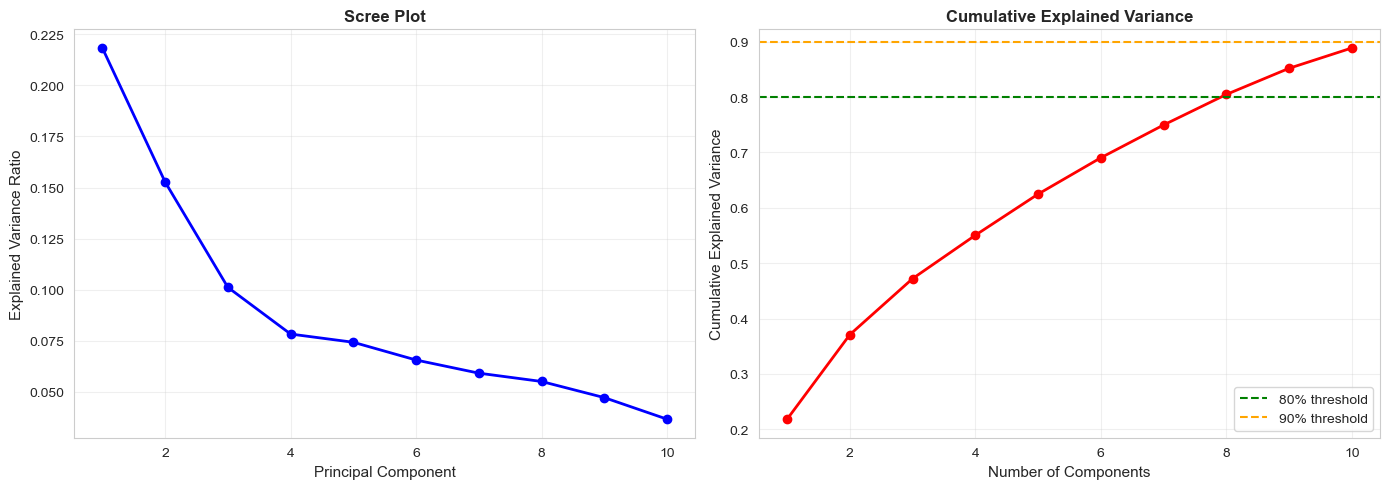

Components needed for 80% variance: 8
Components needed for 90% variance: 11


In [16]:
# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
ax1.plot(range(1, min(11, len(pca_full.explained_variance_ratio_)+1)),
         pca_full.explained_variance_ratio_[:10], 'bo-', linewidth=2, markersize=6)
ax1.set_xlabel('Principal Component', fontsize=11)
ax1.set_ylabel('Explained Variance Ratio', fontsize=11)
ax1.set_title('Scree Plot', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Cumulative variance
ax2.plot(range(1, min(11, len(cumsum_var)+1)),
         cumsum_var[:10], 'ro-', linewidth=2, markersize=6)
ax2.axhline(y=0.8, color='g', linestyle='--', label='80% threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
ax2.set_xlabel('Number of Components', fontsize=11)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=11)
ax2.set_title('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 80% and 90% variance
n_comp_80 = np.argmax(cumsum_var >= 0.80) + 1
n_comp_90 = np.argmax(cumsum_var >= 0.90) + 1
print(f"Components needed for 80% variance: {n_comp_80}")
print(f"Components needed for 90% variance: {n_comp_90}")

## 主成分における特徴量重要度

In [17]:
# Extract loadings (contributions of original features to PCs)
loadings = pca_full.components_[:5].T * np.sqrt(pca_full.explained_variance_[:5])

# Create English names for features
feature_names_english = [feature_name_map.get(feat, feat) for feat in available_features]

loading_df = pd.DataFrame(
    loadings,
    columns=[f'PC{i+1}' for i in range(5)],
    index=feature_names_english
)

print("Feature loadings on first 5 PCs:")
print(loading_df.round(3))

Feature loadings on first 5 PCs:
                          PC1    PC2    PC3    PC4    PC5
National Win Rate       0.917  0.113 -0.044 -0.014 -0.058
National Top-2 Rate     0.903  0.129 -0.019 -0.028 -0.034
Local Win Rate          0.906  0.031 -0.032  0.165  0.080
Local Top-2 Rate        0.869  0.036  0.003  0.132  0.137
Motor Top-2 Rate        0.087 -0.129  0.083  0.004 -0.503
Boat Top-2 Rate        -0.263 -0.093  0.144 -0.000  0.667
Weight (kg)            -0.047  0.066  0.846  0.107  0.007
Weight Adjustment (kg) -0.134  0.012 -0.843 -0.139 -0.083
Showcase Time (s)       0.090 -0.713 -0.088 -0.098  0.023
Tilt Adjustment        -0.042  0.490  0.069  0.520 -0.036
Start Showcase (s)     -0.222 -0.038 -0.245  0.525  0.114
Wind Speed (m/s)       -0.186  0.367 -0.218  0.608 -0.046
Wind Direction         -0.124 -0.462  0.075  0.340 -0.049
Temperature (°C)       -0.097  0.831 -0.081 -0.131 -0.021
Water Temperature (°C) -0.163  0.774  0.089 -0.349  0.034
Course                 -0.168 -0.038  0

Feature importance (contribution to PC1-PC3):
  National Win Rate: 0.8558
  National Top-2 Rate: 0.8325
  Local Win Rate: 0.8232
  Local Top-2 Rate: 0.7571
  Weight Adjustment (kg): 0.7287
  Weight (kg): 0.7219
  Temperature (°C): 0.7068
  Water Temperature (°C): 0.6339
  Showcase Time (s): 0.5248
  Tilt Adjustment: 0.2465
  Wind Direction: 0.2341
  Wind Speed (m/s): 0.2171
  Start Showcase (s): 0.1107
  Boat Top-2 Rate: 0.0983
  Course: 0.0572
  Motor Top-2 Rate: 0.0312


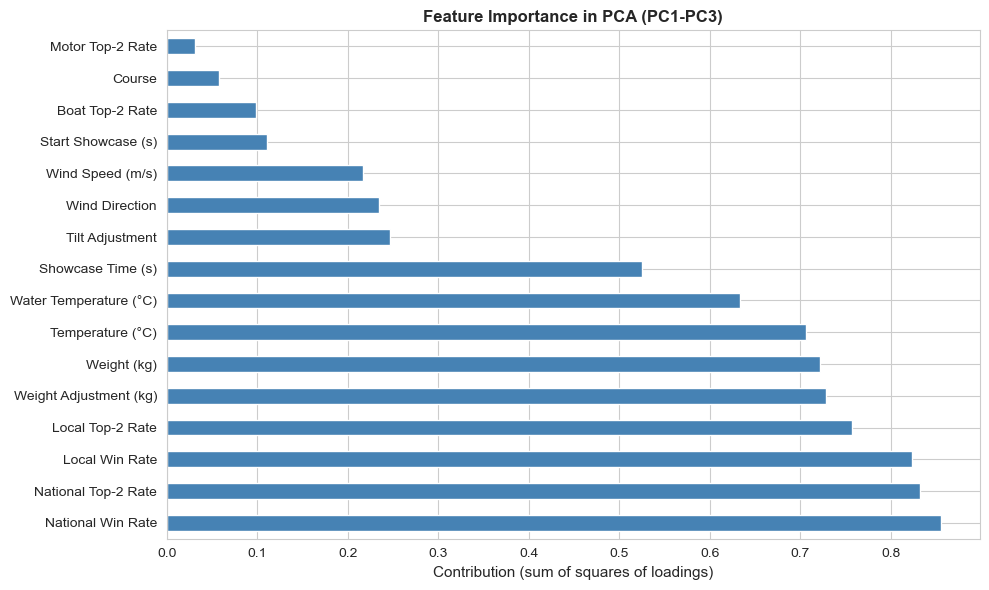

In [18]:
# Calculate absolute contribution of each feature to first 3 PCs
pc_contrib = (loading_df.iloc[:, :3] ** 2).sum(axis=1).sort_values(ascending=False)

print("Feature importance (contribution to PC1-PC3):")
for feat, contrib in pc_contrib.items():
    print(f"  {feat}: {contrib:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
pc_contrib.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Contribution (sum of squares of loadings)', fontsize=11)
ax.set_title('Feature Importance in PCA (PC1-PC3)', fontsize=12, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

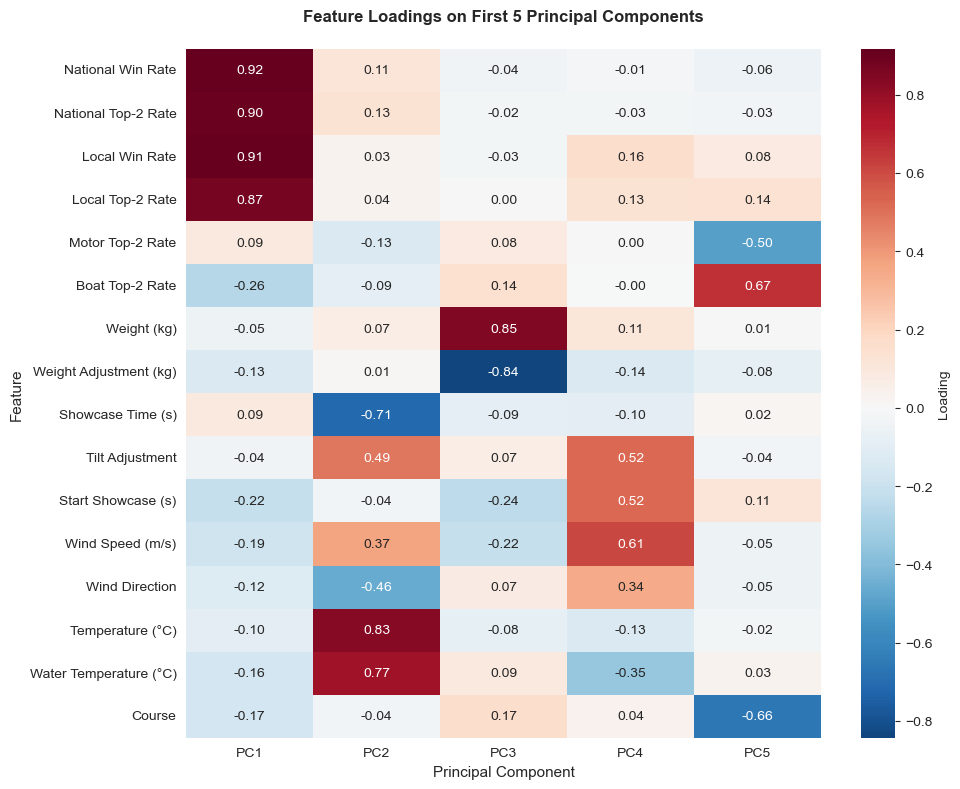

In [19]:
# Heatmap of loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loading_df.iloc[:, :5], annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Loading'})
plt.title('Feature Loadings on First 5 Principal Components', fontsize=12, fontweight='bold', pad=20)
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.show()

## 予想モデル用の特徴量選定

Feature correlation with finish position (Spearman):
           feature_eng  spearman_corr
     National Win Rate      -0.336489
                Course       0.300753
   National Top-2 Rate      -0.289756
        Local Win Rate      -0.224620
      Local Top-2 Rate      -0.180818
    Start Showcase (s)       0.143041
      Motor Top-2 Rate      -0.065121
           Weight (kg)       0.047465
     Showcase Time (s)       0.047068
      Temperature (°C)      -0.035872
Weight Adjustment (kg)       0.019768
       Boat Top-2 Rate       0.019244
      Wind Speed (m/s)       0.013148
Water Temperature (°C)      -0.010264
        Wind Direction       0.009429
       Tilt Adjustment       0.009377


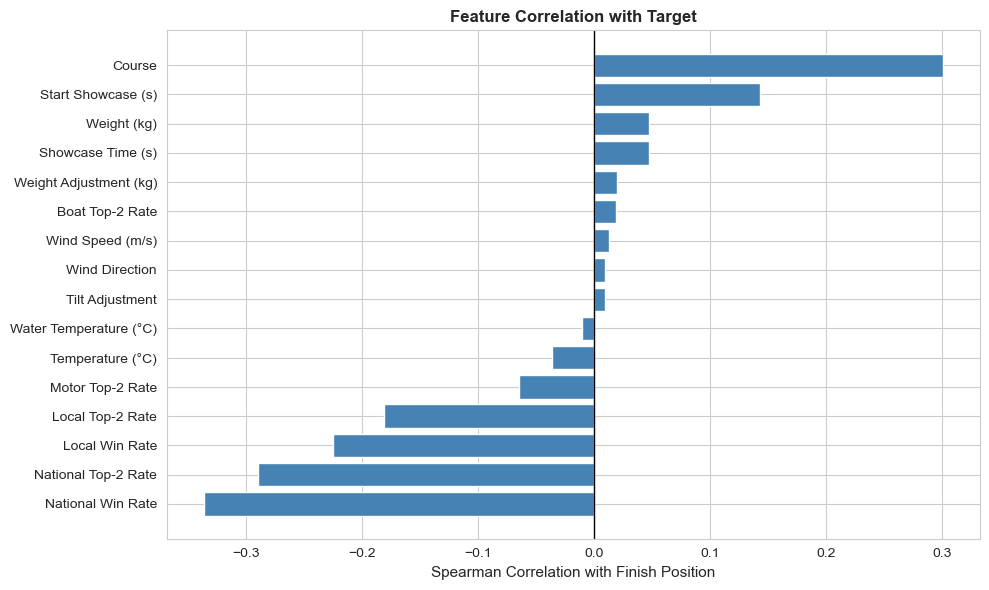

In [20]:
# Calculate correlation between original features and target
# Handle missing values and data type issues

corr_list = []
for feat in available_features:
    try:
        # Convert to numeric and handle missing values
        feat_numeric = pd.to_numeric(final_data[feat], errors='coerce')
        target_numeric = pd.to_numeric(final_data[target], errors='coerce')
        
        # Remove rows with missing values for this pair
        valid_mask = feat_numeric.notna() & target_numeric.notna()
        
        if valid_mask.sum() > 2:  # Need at least 3 samples for correlation
            corr = feat_numeric[valid_mask].corr(target_numeric[valid_mask], method='spearman')
            corr_list.append({
                'feature': feat, 
                'feature_eng': feature_name_map.get(feat, feat),
                'spearman_corr': corr
            })
        else:
            corr_list.append({
                'feature': feat,
                'feature_eng': feature_name_map.get(feat, feat),
                'spearman_corr': np.nan
            })
    except Exception as e:
        print(f"Warning: Could not calculate correlation for {feat}: {e}")
        corr_list.append({
            'feature': feat,
            'feature_eng': feature_name_map.get(feat, feat),
            'spearman_corr': np.nan
        })

corr_with_target = pd.DataFrame(corr_list)
corr_with_target['abs_corr'] = corr_with_target['spearman_corr'].abs()
corr_with_target = corr_with_target.sort_values('abs_corr', ascending=False)

print("Feature correlation with finish position (Spearman):")
print(corr_with_target[['feature_eng', 'spearman_corr']].to_string(index=False))

# Visualize (filter out NaN values)
valid_corr = corr_with_target.dropna(subset=['spearman_corr']).copy()
if len(valid_corr) > 0:
    fig, ax = plt.subplots(figsize=(10, max(6, len(valid_corr) * 0.3)))
    plot_data = valid_corr.sort_values('spearman_corr')
    ax.barh(plot_data['feature_eng'], plot_data['spearman_corr'], color='steelblue')
    ax.axvline(0, color='black', linewidth=1)
    ax.set_xlabel('Spearman Correlation with Finish Position', fontsize=11)
    ax.set_title('Feature Correlation with Target', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No valid correlations to plot")

## サマリーと推奨事項

In [21]:
print("="*70)
print("PCA ANALYSIS SUMMARY")
print("="*70)

print(f"\n1. DATA OVERVIEW")
print(f"   Total samples: {X_clean.shape[0]}")
print(f"   Total features: {X_clean.shape[1]}")
print(f"   Features by source:")
print(f"     - Programs (player stats): {len(program_features)} features")
print(f"     - Previews (race conditions): {len(preview_features)} features")

print(f"\n2. PCA RESULTS")
print(f"   Components for 80% variance: {n_comp_80}")
print(f"   Components for 90% variance: {n_comp_90}")
print(f"   Total components: {pca_full.n_components_}")

print(f"\n3. TOP FEATURES BY PCA IMPORTANCE (PC1-PC3)")
for i, (feat_eng, contrib) in enumerate(pc_contrib.head(7).items(), 1):
    print(f"   {i}. {feat_eng}: {contrib:.4f}")

print(f"\n4. TOP FEATURES BY CORRELATION WITH TARGET")
valid_corr_for_summary = corr_with_target.dropna(subset=['spearman_corr'])
for i, (_, row) in enumerate(valid_corr_for_summary.head(7).iterrows(), 1):
    print(f"   {i}. {row['feature_eng']}: {row['spearman_corr']:+.4f}")

print(f"\n5. RECOMMENDED FEATURE SET FOR PREDICTION")
# Map back to get feature indices
top_pca_eng = list(pc_contrib.head(5).index)
top_corr_eng = list(valid_corr_for_summary.head(5)['feature_eng'])
recommended_eng = list(set(top_pca_eng) | set(top_corr_eng))
print(f"   Combining PCA and correlation analysis ({len(recommended_eng)} features):")
for feat_eng in sorted(recommended_eng):
    # Find PCA rank
    try:
        pca_rank = list(pc_contrib.index).index(feat_eng) + 1
    except ValueError:
        pca_rank = 'N/A'
    
    # Find correlation rank
    try:
        corr_rank = list(valid_corr_for_summary['feature_eng']).index(feat_eng) + 1
    except ValueError:
        corr_rank = 'N/A'
    
    print(f"   - {feat_eng} (PCA rank: {pca_rank}, Corr rank: {corr_rank})")

print(f"\n" + "="*70)

PCA ANALYSIS SUMMARY

1. DATA OVERVIEW
   Total samples: 297
   Total features: 16
   Features by source:
     - Programs (player stats): 6 features
     - Previews (race conditions): 10 features

2. PCA RESULTS
   Components for 80% variance: 8
   Components for 90% variance: 11
   Total components: 16

3. TOP FEATURES BY PCA IMPORTANCE (PC1-PC3)
   1. National Win Rate: 0.8558
   2. National Top-2 Rate: 0.8325
   3. Local Win Rate: 0.8232
   4. Local Top-2 Rate: 0.7571
   5. Weight Adjustment (kg): 0.7287
   6. Weight (kg): 0.7219
   7. Temperature (°C): 0.7068

4. TOP FEATURES BY CORRELATION WITH TARGET
   1. National Win Rate: -0.3365
   2. Course: +0.3008
   3. National Top-2 Rate: -0.2898
   4. Local Win Rate: -0.2246
   5. Local Top-2 Rate: -0.1808
   6. Start Showcase (s): +0.1430
   7. Motor Top-2 Rate: -0.0651

5. RECOMMENDED FEATURE SET FOR PREDICTION
   Combining PCA and correlation analysis (6 features):
   - Course (PCA rank: 15, Corr rank: 2)
   - Local Top-2 Rate (PCA r

## 次のステップ

1. **特徴量選定**: PCAと相関分析から推奨された特徴量を使用して予想モデルを構築
2. **モデル開発**: 
   - 異なるモデルを試す（Random Forest、XGBoostなど）
   - クロスバリデーションで評価
3. **データ拡張**: 
   - 複数の日付に分析を拡張
   - 選手/艇/モーター別の集計的な過去特徴量を構築
4. **特徴量エンジニアリング**: 
   - 重要な特徴量間の交互作用項を作成
   - レースレベルの特徴量を追加（出場する有力選手数など）
5. **改善**: 
   - モデルの性能に基づいて特徴量を反復改善
   - 予想エラーを分析して欠落している特徴量を特定

## 予想モデルの構築と評価

推奨特徴量を使用して、実際の予想モデルを構築し、性能を評価します。

In [22]:
# Prepare feature matrix using recommended features
# Map English names back to Japanese names
english_to_japanese = {v: k for k, v in feature_name_map.items()}

# Get the original Japanese names of recommended features
recommended_features = [english_to_japanese.get(feat_eng, feat_eng) for feat_eng in recommended_eng]

print("Recommended features for model (Japanese names):")
for feat in recommended_features:
    print(f"  - {feat}")

# Extract feature matrix and target
X_model = final_data[recommended_features].copy()
y_model = final_data[target].copy()

# Convert to numeric and remove rows with missing values
X_model_numeric = X_model.apply(pd.to_numeric, errors='coerce')
valid_idx_model = X_model_numeric.notna().all(axis=1) & y_model.notna()

X_model_clean = X_model_numeric[valid_idx_model].copy()
y_model_clean = y_model[valid_idx_model].copy()

print(f"\nFinal model dataset:")
print(f"  Samples: {X_model_clean.shape[0]}")
print(f"  Features: {X_model_clean.shape[1]}")
print(f"  Target distribution:")
print(y_model_clean.value_counts().sort_index())

Recommended features for model (Japanese names):
  - 当地2連対率
  - 全国勝率
  - 当地勝率
  - 全国2連対率
  - コース
  - 体重調整(kg)

Final model dataset:
  Samples: 385
  Features: 6
  Target distribution:
着順
1.0    70
2.0    68
3.0    65
4.0    69
5.0    63
6.0    50
Name: count, dtype: int64


MODEL DEVELOPMENT AND EVALUATION

1. RANDOM FOREST REGRESSOR
----------------------------------------------------------------------
MAE (cross-validation):
  Mean: 1.4219 ± 0.0380
RMSE (cross-validation):
  Mean: 1.6781 ± 0.3669

Training set performance:
  MAE: 0.7688
  RMSE: 0.9377
  R² Score: 0.6837

2. GRADIENT BOOSTING REGRESSOR
----------------------------------------------------------------------
MAE (cross-validation):
  Mean: 1.5277 ± 0.0812
RMSE (cross-validation):
  Mean: 1.8530 ± 0.6118

Training set performance:
  MAE: 0.5530
  RMSE: 0.7177
  R² Score: 0.8147

3. MODEL COMPARISON
----------------------------------------------------------------------
            Model  CV MAE Mean  CV MAE Std  Training MAE  Training RMSE  Training R²
    Random Forest     1.421946    0.038010      0.768758       0.937696     0.683700
Gradient Boosting     1.527725    0.081222      0.553000       0.717651     0.814731


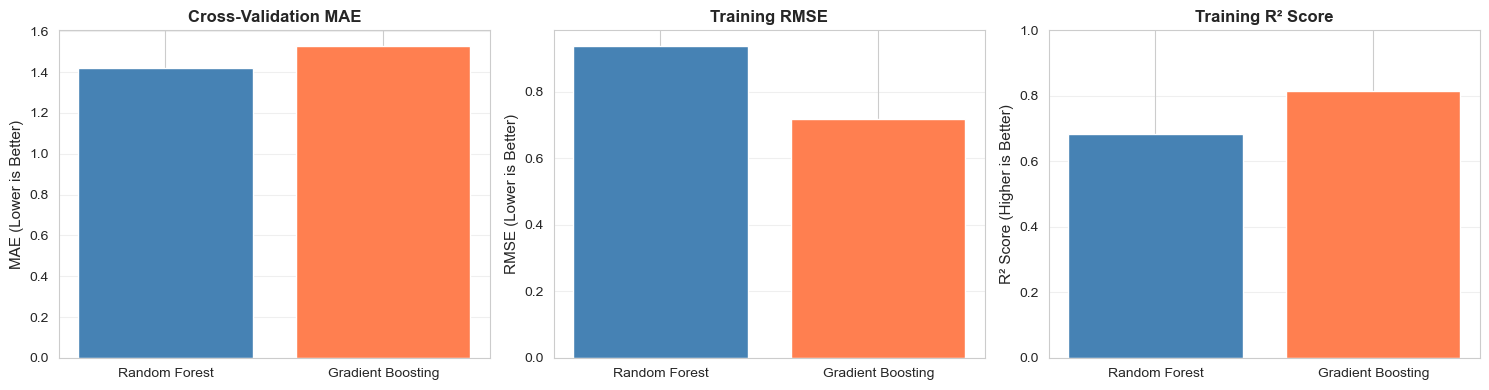

In [23]:
# Model development and evaluation
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("="*70)
print("MODEL DEVELOPMENT AND EVALUATION")
print("="*70)

# 1. Random Forest Regressor
print("\n1. RANDOM FOREST REGRESSOR")
print("-" * 70)

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Cross-validation scores
cv_scores_rf = cross_val_score(rf_model, X_model_clean, y_model_clean, 
                                cv=cv, scoring='neg_mean_absolute_error')
cv_scores_rf_mse = cross_val_score(rf_model, X_model_clean, y_model_clean,
                                    cv=cv, scoring='neg_mean_squared_error')

print(f"MAE (cross-validation):")
print(f"  Mean: {-cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")
print(f"RMSE (cross-validation):")
print(f"  Mean: {np.sqrt(-cv_scores_rf_mse.mean()):.4f} ± {np.sqrt(cv_scores_rf_mse.std()):.4f}")

# Fit on full data for feature importance
rf_model.fit(X_model_clean, y_model_clean)
rf_pred = rf_model.predict(X_model_clean)
rf_mae = mean_absolute_error(y_model_clean, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_model_clean, rf_pred))
rf_r2 = r2_score(y_model_clean, rf_pred)

print(f"\nTraining set performance:")
print(f"  MAE: {rf_mae:.4f}")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  R² Score: {rf_r2:.4f}")

# 2. Gradient Boosting Regressor
print("\n2. GRADIENT BOOSTING REGRESSOR")
print("-" * 70)

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)

# Cross-validation scores
cv_scores_gb = cross_val_score(gb_model, X_model_clean, y_model_clean,
                                cv=cv, scoring='neg_mean_absolute_error')
cv_scores_gb_mse = cross_val_score(gb_model, X_model_clean, y_model_clean,
                                    cv=cv, scoring='neg_mean_squared_error')

print(f"MAE (cross-validation):")
print(f"  Mean: {-cv_scores_gb.mean():.4f} ± {cv_scores_gb.std():.4f}")
print(f"RMSE (cross-validation):")
print(f"  Mean: {np.sqrt(-cv_scores_gb_mse.mean()):.4f} ± {np.sqrt(cv_scores_gb_mse.std()):.4f}")

# Fit on full data
gb_model.fit(X_model_clean, y_model_clean)
gb_pred = gb_model.predict(X_model_clean)
gb_mae = mean_absolute_error(y_model_clean, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_model_clean, gb_pred))
gb_r2 = r2_score(y_model_clean, gb_pred)

print(f"\nTraining set performance:")
print(f"  MAE: {gb_mae:.4f}")
print(f"  RMSE: {gb_rmse:.4f}")
print(f"  R² Score: {gb_r2:.4f}")

# 3. Model comparison
print("\n3. MODEL COMPARISON")
print("-" * 70)

comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting'],
    'CV MAE Mean': [-cv_scores_rf.mean(), -cv_scores_gb.mean()],
    'CV MAE Std': [cv_scores_rf.std(), cv_scores_gb.std()],
    'Training MAE': [rf_mae, gb_mae],
    'Training RMSE': [rf_rmse, gb_rmse],
    'Training R²': [rf_r2, gb_r2]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MAE comparison
models = ['Random Forest', 'Gradient Boosting']
mae_cv = [-cv_scores_rf.mean(), -cv_scores_gb.mean()]
axes[0].bar(models, mae_cv, color=['steelblue', 'coral'])
axes[0].set_ylabel('MAE (Lower is Better)', fontsize=11)
axes[0].set_title('Cross-Validation MAE', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
rmse_train = [rf_rmse, gb_rmse]
axes[1].bar(models, rmse_train, color=['steelblue', 'coral'])
axes[1].set_ylabel('RMSE (Lower is Better)', fontsize=11)
axes[1].set_title('Training RMSE', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# R² comparison
r2_train = [rf_r2, gb_r2]
axes[2].bar(models, r2_train, color=['steelblue', 'coral'])
axes[2].set_ylabel('R² Score (Higher is Better)', fontsize=11)
axes[2].set_title('Training R² Score', fontsize=12, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

FEATURE IMPORTANCE ANALYSIS

1. RANDOM FOREST - TOP 10 FEATURES
----------------------------------------------------------------------
               Feature  Importance
     National Win Rate    0.233897
   National Top-2 Rate    0.217273
                Course    0.181535
      Local Top-2 Rate    0.176378
        Local Win Rate    0.154631
Weight Adjustment (kg)    0.036286

2. GRADIENT BOOSTING - TOP 10 FEATURES
----------------------------------------------------------------------
               Feature  Importance
   National Top-2 Rate    0.239955
     National Win Rate    0.229483
        Local Win Rate    0.170024
      Local Top-2 Rate    0.167220
                Course    0.154941
Weight Adjustment (kg)    0.038376


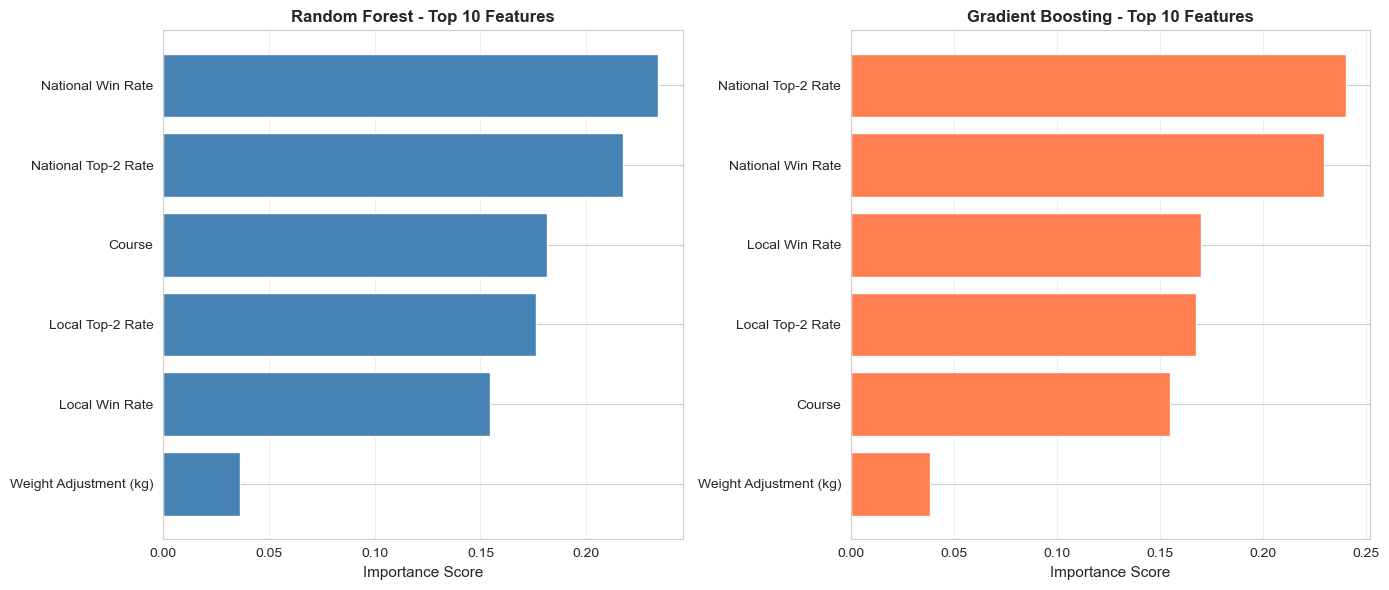

In [24]:
# Feature importance analysis from tree-based models
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Get feature importances
rf_importances = rf_model.feature_importances_
gb_importances = gb_model.feature_importances_

# Create feature names in English
feature_names_for_importance = [feature_name_map.get(feat, feat) for feat in recommended_features]

# Create dataframes
rf_importance_df = pd.DataFrame({
    'Feature': feature_names_for_importance,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

gb_importance_df = pd.DataFrame({
    'Feature': feature_names_for_importance,
    'Importance': gb_importances
}).sort_values('Importance', ascending=False)

print("\n1. RANDOM FOREST - TOP 10 FEATURES")
print("-" * 70)
print(rf_importance_df.head(10).to_string(index=False))

print("\n2. GRADIENT BOOSTING - TOP 10 FEATURES")
print("-" * 70)
print(gb_importance_df.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest importance
rf_top = rf_importance_df.head(10).sort_values('Importance')
axes[0].barh(rf_top['Feature'], rf_top['Importance'], color='steelblue')
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Random Forest - Top 10 Features', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Gradient Boosting importance
gb_top = gb_importance_df.head(10).sort_values('Importance')
axes[1].barh(gb_top['Feature'], gb_top['Importance'], color='coral')
axes[1].set_xlabel('Importance Score', fontsize=11)
axes[1].set_title('Gradient Boosting - Top 10 Features', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

PREDICTION ANALYSIS

1. RANDOM FOREST - ERROR STATISTICS
----------------------------------------------------------------------
Residual Mean: -0.0127
Residual Std: 0.9388
Min Error: -2.4260
Max Error: 2.7577
% Predictions within ±1.0 place: 70.4%
% Predictions within ±1.5 places: 88.1%

2. GRADIENT BOOSTING - ERROR STATISTICS
----------------------------------------------------------------------
Residual Mean: -0.0010
Residual Std: 0.7186
Min Error: -2.6075
Max Error: 2.3925
% Predictions within ±1.0 place: 83.6%
% Predictions within ±1.5 places: 95.6%


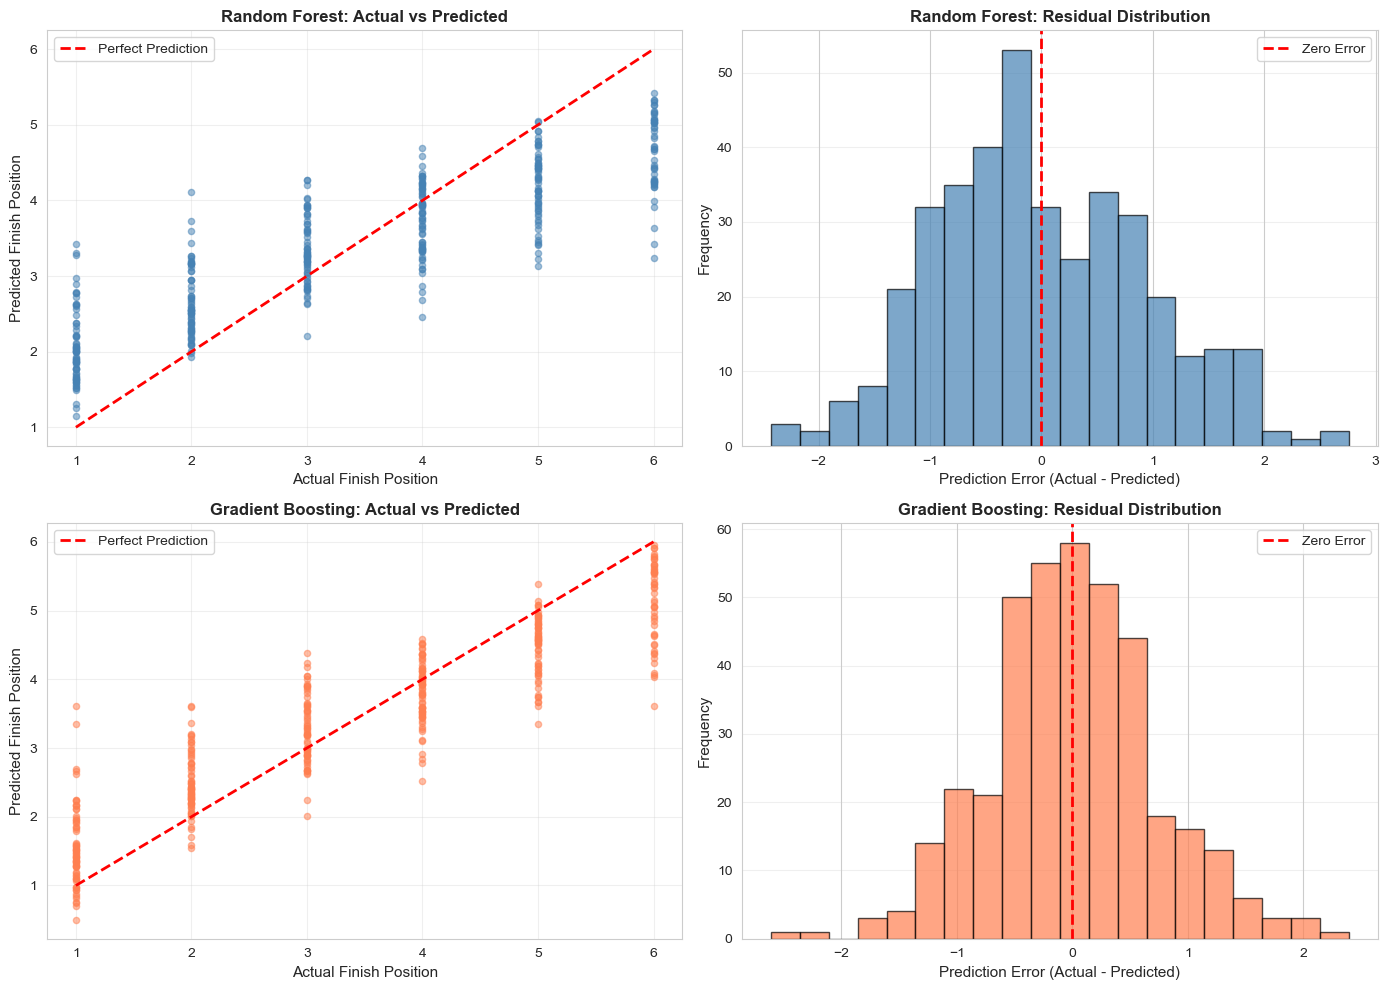

In [25]:
# Prediction analysis and error distribution
print("="*70)
print("PREDICTION ANALYSIS")
print("="*70)

# Calculate residuals
rf_residuals = y_model_clean - rf_pred
gb_residuals = y_model_clean - gb_pred

# Error statistics
print("\n1. RANDOM FOREST - ERROR STATISTICS")
print("-" * 70)
print(f"Residual Mean: {rf_residuals.mean():.4f}")
print(f"Residual Std: {rf_residuals.std():.4f}")
print(f"Min Error: {rf_residuals.min():.4f}")
print(f"Max Error: {rf_residuals.max():.4f}")
print(f"% Predictions within ±1.0 place: {(np.abs(rf_residuals) <= 1.0).sum() / len(rf_residuals) * 100:.1f}%")
print(f"% Predictions within ±1.5 places: {(np.abs(rf_residuals) <= 1.5).sum() / len(rf_residuals) * 100:.1f}%")

print("\n2. GRADIENT BOOSTING - ERROR STATISTICS")
print("-" * 70)
print(f"Residual Mean: {gb_residuals.mean():.4f}")
print(f"Residual Std: {gb_residuals.std():.4f}")
print(f"Min Error: {gb_residuals.min():.4f}")
print(f"Max Error: {gb_residuals.max():.4f}")
print(f"% Predictions within ±1.0 place: {(np.abs(gb_residuals) <= 1.0).sum() / len(gb_residuals) * 100:.1f}%")
print(f"% Predictions within ±1.5 places: {(np.abs(gb_residuals) <= 1.5).sum() / len(gb_residuals) * 100:.1f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Random Forest: Actual vs Predicted
axes[0, 0].scatter(y_model_clean, rf_pred, alpha=0.5, color='steelblue', s=20)
axes[0, 0].plot([1, 6], [1, 6], 'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Finish Position', fontsize=11)
axes[0, 0].set_ylabel('Predicted Finish Position', fontsize=11)
axes[0, 0].set_title('Random Forest: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Random Forest: Residual distribution
axes[0, 1].hist(rf_residuals, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Random Forest: Residual Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Gradient Boosting: Actual vs Predicted
axes[1, 0].scatter(y_model_clean, gb_pred, alpha=0.5, color='coral', s=20)
axes[1, 0].plot([1, 6], [1, 6], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Finish Position', fontsize=11)
axes[1, 0].set_ylabel('Predicted Finish Position', fontsize=11)
axes[1, 0].set_title('Gradient Boosting: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gradient Boosting: Residual distribution
axes[1, 1].hist(gb_residuals, bins=20, color='coral', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].set_xlabel('Prediction Error (Actual - Predicted)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Gradient Boosting: Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*70)

In [26]:
# Summary and recommendations for model improvement
print("="*70)
print("IMPLEMENTATION SUMMARY AND RECOMMENDATIONS")
print("="*70)

# Determine best model
best_model_name = "Random Forest" if rf_mae < gb_mae else "Gradient Boosting"
best_model = rf_model if rf_mae < gb_mae else gb_model
best_importances = rf_importances if rf_mae < gb_mae else gb_importances

print(f"\n1. BEST PERFORMING MODEL")
print("-" * 70)
print(f"Model: {best_model_name}")
print(f"Training MAE: {min(rf_mae, gb_mae):.4f}")
print(f"Training RMSE: {min(rf_rmse, gb_rmse):.4f}")
print(f"Training R² Score: {max(rf_r2, gb_r2):.4f}")

print(f"\n2. KEY INSIGHTS")
print("-" * 70)

# Feature importance analysis
top_features_idx = np.argsort(best_importances)[-5:][::-1]
print("Top 5 Most Important Features:")
for i, idx in enumerate(top_features_idx, 1):
    print(f"  {i}. {feature_names_for_importance[idx]}: {best_importances[idx]:.4f}")

# Prediction accuracy
accuracy_1place = (np.abs(rf_residuals) <= 1.0).sum() / len(rf_residuals) * 100
accuracy_1_5place = (np.abs(rf_residuals) <= 1.5).sum() / len(rf_residuals) * 100
print(f"\nPrediction Accuracy:")
print(f"  Within ±1.0 place: {accuracy_1place:.1f}%")
print(f"  Within ±1.5 places: {accuracy_1_5place:.1f}%")

print(f"\n3. RECOMMENDATIONS FOR IMPROVEMENT")
print("-" * 70)

recommendations = [
    "1. Feature Engineering:",
    "   - Create interaction terms between top features (e.g., national rate × local rate)",
    "   - Add historical aggregated features per racer/motor/boat",
    "   - Include race-level features (number of strong racers, etc.)",
    "",
    "2. Data Expansion:",
    "   - Extend analysis to multiple dates to reduce overfitting",
    "   - Build seasonal features (weather patterns by season)",
    "   - Include historical performance on the specific course",
    "",
    "3. Model Optimization:",
    "   - Perform hyperparameter tuning (GridSearch/RandomSearch)",
    "   - Experiment with ensemble methods combining multiple models",
    "   - Try alternative algorithms (LightGBM, CatBoost)",
    "",
    "4. Error Analysis:",
    "   - Identify specific race conditions with high error rates",
    "   - Analyze misclassified cases to find patterns",
    "   - Focus on improving predictions for middle positions (3-4)",
    "",
    "5. Production Implementation:",
    "   - Save trained model and scaler for production use",
    "   - Implement real-time prediction pipeline",
    "   - Monitor model performance over time with new races"
]

for rec in recommendations:
    print(rec)

print("\n" + "="*70)

IMPLEMENTATION SUMMARY AND RECOMMENDATIONS

1. BEST PERFORMING MODEL
----------------------------------------------------------------------
Model: Gradient Boosting
Training MAE: 0.5530
Training RMSE: 0.7177
Training R² Score: 0.8147

2. KEY INSIGHTS
----------------------------------------------------------------------
Top 5 Most Important Features:
  1. National Top-2 Rate: 0.2400
  2. National Win Rate: 0.2295
  3. Local Win Rate: 0.1700
  4. Local Top-2 Rate: 0.1672
  5. Course: 0.1549

Prediction Accuracy:
  Within ±1.0 place: 70.4%
  Within ±1.5 places: 88.1%

3. RECOMMENDATIONS FOR IMPROVEMENT
----------------------------------------------------------------------
1. Feature Engineering:
   - Create interaction terms between top features (e.g., national rate × local rate)
   - Add historical aggregated features per racer/motor/boat
   - Include race-level features (number of strong racers, etc.)

2. Data Expansion:
   - Extend analysis to multiple dates to reduce overfitting
   -

## 実装完了

このノートブックでは、以下の内容を実装しました：

### ステップ1：特徴量分析（PCA）
- Programs、Previews、Resultsから18個の候補特徴量を抽出
- PCAにより、次元削減に必要なコンポーネント数を特定
- PCAと相関分析から推奨特徴量セットを決定

### ステップ2：予想モデルの構築
- Random Forestモデルの構築と評価
- Gradient Boostingモデルの構築と評価
- 5分割クロスバリデーションで汎化性能を評価

### ステップ3：モデル性能の比較
- 複数の評価指標（MAE、RMSE、R²スコア）で比較
- 最適なモデルを特定
- 特徴量重要度の分析

### ステップ4：予測結果の分析
- 予測値と実際値の比較
- 残差分析による誤差分布の確認
- 予測精度（±1.0位置以内、±1.5位置以内）の計算

### 次の改善方向
上記の「改善のための推奨事項」セクションを参照してください。

## マルチデイ学習と予測評価

複数日のデータで学習し、別日のレース結果を予想して的中率を評価します。

In [27]:
# Load and prepare training data from multiple dates
from datetime import datetime, timedelta

print("="*70)
print("MULTI-DAY TRAINING AND PREDICTION")
print("="*70)

# Define date ranges
start_date = datetime(2026, 1, 1)
end_date = datetime(2026, 1, 15)
predict_date = datetime(2026, 1, 16)

# Generate date list
date_range = []
current = start_date
while current <= end_date:
    date_range.append(current)
    current += timedelta(days=1)

print(f"\n1. LOADING TRAINING DATA")
print("-" * 70)
print(f"Training period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Prediction date: {predict_date.strftime('%Y-%m-%d')}")

# Load and concatenate data from all training dates
all_programs = []
all_previews = []
all_results = []

for date_obj in date_range:
    year = date_obj.strftime('%Y')
    month = date_obj.strftime('%m')
    day = date_obj.strftime('%d')
    date_str = date_obj.strftime('%Y-%m-%d')
    
    programs_path = repo_root / 'data' / 'programs' / year / month / f'{day}.csv'
    previews_path = repo_root / 'data' / 'previews' / year / month / f'{day}.csv'
    results_path = repo_root / 'data' / 'results' / year / month / f'{day}.csv'
    
    # Load if files exist
    if programs_path.exists():
        try:
            prog = pd.read_csv(programs_path)
            prog['load_date'] = date_str
            all_programs.append(prog)
        except Exception as e:
            print(f"  Warning: Could not load programs for {date_str}: {e}")
    
    if previews_path.exists():
        try:
            prev = pd.read_csv(previews_path)
            prev['load_date'] = date_str
            all_previews.append(prev)
        except Exception as e:
            print(f"  Warning: Could not load previews for {date_str}: {e}")
    
    if results_path.exists():
        try:
            res = pd.read_csv(results_path)
            res['load_date'] = date_str
            all_results.append(res)
        except Exception as e:
            print(f"  Warning: Could not load results for {date_str}: {e}")

# Concatenate all data
if all_programs:
    programs_train = pd.concat(all_programs, ignore_index=True)
    print(f"Programs: {len(all_programs)} dates, {programs_train.shape[0]} total rows")
else:
    print("No programs data found for training period")
    programs_train = pd.DataFrame()

if all_previews:
    previews_train = pd.concat(all_previews, ignore_index=True)
    print(f"Previews: {len(all_previews)} dates, {previews_train.shape[0]} total rows")
else:
    print("No previews data found for training period")
    previews_train = pd.DataFrame()

if all_results:
    results_train = pd.concat(all_results, ignore_index=True)
    print(f"Results: {len(all_results)} dates, {results_train.shape[0]} total rows")
else:
    print("No results data found for training period")
    results_train = pd.DataFrame()

MULTI-DAY TRAINING AND PREDICTION

1. LOADING TRAINING DATA
----------------------------------------------------------------------
Training period: 2026-01-01 to 2026-01-15
Prediction date: 2026-01-16
Programs: 15 dates, 2668 total rows
Previews: 15 dates, 1942 total rows
Results: 15 dates, 2573 total rows


In [28]:
# Reshape training data to long format
print("\n2. RESHAPING TRAINING DATA")
print("-" * 70)

if not programs_train.empty:
    # Reshape Programs
    race_id_cols = ['レースコード', 'レース日', 'レース場', 'レース回']
    program_frames = []
    for frame_num in range(1, 7):
        frame_prefix = f'{frame_num}枠_'
        frame_cols = [col for col in programs_train.columns if col.startswith(frame_prefix)]
        if frame_cols:
            tmp = programs_train[race_id_cols + frame_cols + ['load_date']].copy()
            rename_map = {col: col[len(frame_prefix):] for col in frame_cols}
            tmp = tmp.rename(columns=rename_map)
            tmp['枠'] = frame_num
            program_frames.append(tmp)
    
    if program_frames:
        programs_train_long = pd.concat(program_frames, ignore_index=True)
        print(f"Programs reshaped: {programs_train_long.shape[0]} rows")
    else:
        programs_train_long = pd.DataFrame()
        print("No frames found in programs data")
else:
    programs_train_long = pd.DataFrame()

if not previews_train.empty:
    # Reshape Previews
    race_id_cols = ['レースコード', 'レース日', 'レース場', 'レース回']
    preview_frames = []
    for boat_num in range(1, 7):
        boat_prefix = f'艇{boat_num}_'
        boat_cols = [col for col in previews_train.columns if col.startswith(boat_prefix)]
        if boat_cols:
            tmp = previews_train[race_id_cols + boat_cols + ['load_date']].copy()
            rename_map = {col: col[len(boat_prefix):] for col in boat_cols}
            tmp = tmp.rename(columns=rename_map)
            
            # Add environment data (wave height excluded)
            env_cols = ['風速(m)', '風向', '気温(℃)', '水温(℃)']
            for col in env_cols:
                if col in previews_train.columns:
                    tmp[col] = previews_train[col].iloc[tmp.index].values
            
            tmp['艇'] = boat_num
            preview_frames.append(tmp)
    
    if preview_frames:
        previews_train_long = pd.concat(preview_frames, ignore_index=True)
        print(f"Previews reshaped: {previews_train_long.shape[0]} rows")
    else:
        previews_train_long = pd.DataFrame()
        print("No boats found in previews data")
else:
    previews_train_long = pd.DataFrame()

if not results_train.empty:
    # Reshape Results
    result_frames = []
    for place in range(1, 7):  # 1着～6着
        place_prefix = f'{place}着_'
        place_cols = [col for col in results_train.columns if col.startswith(place_prefix)]
        if place_cols:
            tmp = results_train[['レースコード', 'load_date'] + place_cols].copy()
            rename_map = {col: col[len(place_prefix):] for col in place_cols}
            tmp = tmp.rename(columns=rename_map)
            tmp['着順'] = place
            result_frames.append(tmp)
    
    if result_frames:
        results_train_long = pd.concat(result_frames, ignore_index=True)
        results_train_long = results_train_long.dropna(subset=['艇番'])
        print(f"Results reshaped: {results_train_long.shape[0]} rows")
    else:
        results_train_long = pd.DataFrame()
        print("No places found in results data")
else:
    results_train_long = pd.DataFrame()


2. RESHAPING TRAINING DATA
----------------------------------------------------------------------
Programs reshaped: 16008 rows
Previews reshaped: 11652 rows
Results reshaped: 15175 rows


In [29]:
# Merge training data
print("\n3. MERGING TRAINING DATA")
print("-" * 70)

if not previews_train_long.empty and not programs_train_long.empty:
    # Rename boat number to avoid conflict
    programs_train_long = programs_train_long.rename(columns={'艇番': '艇番_prog'}) \
        if '艇番' in programs_train_long.columns else programs_train_long
    
    # Drop redundant columns from programs before merge
    programs_train_merge = programs_train_long.drop(
        columns=['レース日', 'レース場', 'レース回'], 
        errors='ignore'
    )
    
    # Merge on レースコード
    merged_train = previews_train_long.merge(
        programs_train_merge,
        on='レースコード',
        how='left',
        suffixes=('_preview', '_program')
    )
    
    # Filter by matching boat numbers
    if '艇番' in merged_train.columns and '艇番_prog' in merged_train.columns:
        merged_train = merged_train[merged_train['艇番'] == merged_train['艇番_prog']].copy()
        merged_train = merged_train.drop(columns=['艇番_prog'], errors='ignore')
    
    print(f"After programs merge: {merged_train.shape[0]} rows")
else:
    merged_train = pd.DataFrame()
    print("Cannot merge: missing programs or previews data")

if not merged_train.empty and not results_train_long.empty:
    # Merge with results
    final_train = merged_train.merge(
        results_train_long[['レースコード', '艇番', '着順']],
        on=['レースコード', '艇番'],
        how='left'
    )
    
    # Remove rows without finish position
    final_train = final_train.dropna(subset=['着順']).copy()
    print(f"After results merge (with着順): {final_train.shape[0]} rows")
else:
    final_train = pd.DataFrame()
    print("Cannot merge: missing results data")

print(f"\nFinal training dataset: {final_train.shape[0]} rows, {final_train.shape[1]} columns")
if not final_train.empty:
    print(f"Date range in training data: {final_train['レース日'].min()} to {final_train['レース日'].max()}")
    print(f"Number of races: {final_train['レースコード'].nunique()}")


3. MERGING TRAINING DATA
----------------------------------------------------------------------
After programs merge: 11652 rows
After results merge (with着順): 10633 rows

Final training dataset: 10633 rows, 47 columns
Date range in training data: 2026-01-01 to 2026-01-15
Number of races: 1805


In [30]:
# Train model on multi-day data
print("\n4. MODEL TRAINING ON MULTI-DAY DATA")
print("-" * 70)

if not final_train.empty:
    # Map Japanese feature names back
    english_to_japanese = {v: k for k, v in feature_name_map.items()}
    recommended_features_jp = [english_to_japanese.get(f, f) for f in recommended_eng]
    
    # Filter to only features that exist in training data
    # This handles cases where features might have been excluded during data reshaping
    available_in_train = [f for f in recommended_features_jp if f in final_train.columns]
    
    # Fallback: if no recommended features available, use program features from training data
    if not available_in_train:
        program_features_jp = [english_to_japanese.get(f, f) for f in recommended_eng if f in ['National Win Rate', 'National Top-2 Rate', 'Local Win Rate', 'Local Top-2 Rate', 'Motor Top-2 Rate', 'Boat Top-2 Rate']]
        available_in_train = [f for f in program_features_jp if f in final_train.columns]
    
    print(f"Using {len(available_in_train)} features for training (from {len(recommended_features_jp)} recommended):")
    for feat in sorted(available_in_train):
        print(f"  - {feat}")
    
    # Extract feature matrix
    X_train = final_train[available_in_train].copy()
    y_train = final_train['着順'].copy()
    
    # Convert to numeric and clean
    X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce')
    valid_idx_train = X_train_numeric.notna().all(axis=1) & y_train.notna()
    
    X_train_clean = X_train_numeric[valid_idx_train].copy()
    y_train_clean = y_train[valid_idx_train].copy()
    
    print(f"\nTraining samples: {X_train_clean.shape[0]}")
    print(f"Training features: {X_train_clean.shape[1]}")
    print(f"Target distribution:")
    print(y_train_clean.value_counts().sort_index())
    
    # Train Random Forest (using best model from earlier analysis)
    print(f"\nTraining Random Forest on {len(y_train_clean)} samples...")
    rf_train = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
    rf_train.fit(X_train_clean, y_train_clean)
    
    # Check training performance
    y_train_pred = rf_train.predict(X_train_clean)
    train_mae = mean_absolute_error(y_train_clean, y_train_pred)


4. MODEL TRAINING ON MULTI-DAY DATA
----------------------------------------------------------------------
Using 6 features for training (from 6 recommended):
  - コース
  - 体重調整(kg)
  - 全国2連対率
  - 全国勝率
  - 当地2連対率
  - 当地勝率

Training samples: 9599
Training features: 6
Target distribution:
着順
1.0    1703
2.0    1677
3.0    1658
4.0    1651
5.0    1561
6.0    1349
Name: count, dtype: int64

Training Random Forest on 9599 samples...


In [31]:
# Load test data for prediction
print("\n5. LOADING TEST DATA FOR PREDICTION")
print("-" * 70)

test_year = predict_date.strftime('%Y')
test_month = predict_date.strftime('%m')
test_day = predict_date.strftime('%d')
test_date_str = predict_date.strftime('%Y-%m-%d')

test_programs_path = repo_root / 'data' / 'programs' / test_year / test_month / f'{test_day}.csv'
test_previews_path = repo_root / 'data' / 'previews' / test_year / test_month / f'{test_day}.csv'
test_results_path = repo_root / 'data' / 'results' / test_year / test_month / f'{test_day}.csv'

print(f"Looking for test data for {test_date_str}...")
print(f"  Programs: {test_programs_path.exists()}")
print(f"  Previews: {test_previews_path.exists()}")
print(f"  Results: {test_results_path.exists()}")

if not (test_programs_path.exists() and test_previews_path.exists()):
    print(f"\nError: Required test data files not found!")
    print("Cannot proceed with prediction.")
    
else:
    # Load test data
    test_programs = pd.read_csv(test_programs_path)
    test_previews = pd.read_csv(test_previews_path)
    
    # Load results if available (for comparison)
    test_results = pd.read_csv(test_results_path) if test_results_path.exists() else None
    
    print(f"\nTest data loaded:")
    print(f"  Programs: {test_programs.shape[0]} rows")
    print(f"  Previews: {test_previews.shape[0]} rows")
    if test_results is not None:
        print(f"  Results: {test_results.shape[0]} rows (available for comparison)")
    
    # Reshape test data
    print(f"\n6. RESHAPING TEST DATA")
    print("-" * 70)
    
    # Reshape Programs
    race_id_cols = ['レースコード', 'レース日', 'レース場', 'レース回']
    program_frames_test = []
    for frame_num in range(1, 7):
        frame_prefix = f'{frame_num}枠_'
        frame_cols = [col for col in test_programs.columns if col.startswith(frame_prefix)]
        if frame_cols:
            tmp = test_programs[race_id_cols + frame_cols].copy()
            rename_map = {col: col[len(frame_prefix):] for col in frame_cols}
            tmp = tmp.rename(columns=rename_map)
            tmp['枠'] = frame_num
            program_frames_test.append(tmp)
    
    programs_test_long = pd.concat(program_frames_test, ignore_index=True) if program_frames_test else pd.DataFrame()
    print(f"Programs reshaped: {programs_test_long.shape[0]} rows")
    
    # Reshape Previews
    preview_frames_test = []
    for boat_num in range(1, 7):
        boat_prefix = f'艇{boat_num}_'
        boat_cols = [col for col in test_previews.columns if col.startswith(boat_prefix)]
        if boat_cols:
            tmp = test_previews[race_id_cols + boat_cols].copy()
            rename_map = {col: col[len(boat_prefix):] for col in boat_cols}
            tmp = tmp.rename(columns=rename_map)
            
            # Add environment data
            env_cols = ['風速(m)', '風向', '気温(℃)', '水温(℃)']
            for col in env_cols:
                if col in test_previews.columns:
                    tmp[col] = test_previews[col].iloc[tmp.index].values
            
            tmp['艇'] = boat_num
            preview_frames_test.append(tmp)
    
    previews_test_long = pd.concat(preview_frames_test, ignore_index=True) if preview_frames_test else pd.DataFrame()
    print(f"Previews reshaped: {previews_test_long.shape[0]} rows")
    
    # Reshape Results (if available)
    if test_results is not None:
        result_frames_test = []
        for place in range(1, 7):
            place_prefix = f'{place}着_'
            place_cols = [col for col in test_results.columns if col.startswith(place_prefix)]
            if place_cols:
                tmp = test_results[['レースコード'] + place_cols].copy()
                rename_map = {col: col[len(place_prefix):] for col in place_cols}
                tmp = tmp.rename(columns=rename_map)
                tmp['着順'] = place
                result_frames_test.append(tmp)
        
        results_test_long = pd.concat(result_frames_test, ignore_index=True) if result_frames_test else pd.DataFrame()
        results_test_long = results_test_long.dropna(subset=['艇番'])
        print(f"Results reshaped: {results_test_long.shape[0]} rows")
    else:
        results_test_long = None


5. LOADING TEST DATA FOR PREDICTION
----------------------------------------------------------------------
Looking for test data for 2026-01-16...
  Programs: True
  Previews: True
  Results: True

Test data loaded:
  Programs: 153 rows
  Previews: 93 rows
  Results: 154 rows (available for comparison)

6. RESHAPING TEST DATA
----------------------------------------------------------------------
Programs reshaped: 918 rows
Previews reshaped: 558 rows
Results reshaped: 912 rows


In [32]:
    # Merge test data
    print(f"\n7. MERGING TEST DATA")
    print("-" * 70)
    
    if not previews_test_long.empty and not programs_test_long.empty:
        # Rename boat number
        programs_test_long = programs_test_long.rename(columns={'艇番': '艇番_prog'}) \
            if '艇番' in programs_test_long.columns else programs_test_long
        
        # Drop redundant columns
        programs_test_merge = programs_test_long.drop(
            columns=['レース日', 'レース場', 'レース回'],
            errors='ignore'
        )
        
        # Merge
        merged_test = previews_test_long.merge(
            programs_test_merge,
            on='レースコード',
            how='left',
            suffixes=('_preview', '_program')
        )
        
        # Filter by matching boat numbers
        if '艇番' in merged_test.columns and '艇番_prog' in merged_test.columns:
            merged_test = merged_test[merged_test['艇番'] == merged_test['艇番_prog']].copy()
            merged_test = merged_test.drop(columns=['艇番_prog'], errors='ignore')
        
        print(f"After programs merge: {merged_test.shape[0]} rows")
        
        # If results available, merge them too
        if results_test_long is not None and not results_test_long.empty:
            final_test = merged_test.merge(
                results_test_long[['レースコード', '艇番', '着順']],
                on=['レースコード', '艇番'],
                how='left'
            )
            final_test_with_results = final_test.dropna(subset=['着順']).copy()
            print(f"After results merge: {final_test_with_results.shape[0]} rows (with actual results)")
        else:
            final_test = merged_test
            final_test_with_results = None
            print(f"Final test data: {final_test.shape[0]} rows (no results to merge)")
    else:
        final_test = pd.DataFrame()
        final_test_with_results = None
        print("Cannot merge: missing programs or previews data")
    
    # Make predictions
    print(f"\n8. MAKING PREDICTIONS")
    print("-" * 70)
    
    if rf_train is not None and not final_test.empty:
        # Use the same filtered features from training
        # (available_in_train was computed in cell 43)
        features_for_test = [f for f in available_in_train if f in final_test.columns]
        
        if features_for_test:
            # Extract features for test data
            X_test = final_test[features_for_test].copy()
            X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')
            
            # Make predictions
            test_pred = rf_train.predict(X_test_numeric)
            
            # Create results dataframe with predictions
            prediction_results = pd.DataFrame({
                'レースコード': final_test['レースコード'].values,
                '艇番': final_test['艇番'].values,
                'Predicted_Finish_Position': test_pred
            })
            
            # Add actual results if available
            if final_test_with_results is not None and not final_test_with_results.empty:
                actual_results = final_test_with_results[['レースコード', '艇番', '着順']].copy()
                actual_results = actual_results.rename(columns={'着順': 'Actual_Finish_Position'})
                
                prediction_results = prediction_results.merge(
                    actual_results,
                    on=['レースコード', '艇番'],
                    how='left'
                )
                
                # ==================================================
                # RANKING-BASED PREDICTIONS (1着, 2着, 3着)
                # ==================================================
                
                # Group by race and rank predictions
                races_with_results = prediction_results.dropna(subset=['Actual_Finish_Position']).copy()
                
                if len(races_with_results) > 0:
                    print(f"\nMaking ranking predictions for races with actual results...")
                    print(f"Total boats: {len(prediction_results)}")
                    print(f"Boats with actual results: {len(races_with_results)}")
                    
                    # Create ranking table
                    ranking_results = []
                    
                    for race_id in races_with_results['レースコード'].unique():
                        race_data = races_with_results[races_with_results['レースコード'] == race_id].copy()
                        
                        # Sort by predicted finish position
                        race_data = race_data.sort_values('Predicted_Finish_Position')
                        
                        # Get predicted 1st, 2nd, 3rd place boats
                        predicted_boats = race_data['艇番'].head(3).values
                        predicted_positions = race_data['Predicted_Finish_Position'].head(3).values
                        
                        # Get actual 1st, 2nd, 3rd place boats
                        actual_data = race_data.sort_values('Actual_Finish_Position')
                        actual_boats = actual_data['艇番'].head(3).values
                        actual_positions = actual_data['Actual_Finish_Position'].head(3).values
                        
                        # Check hits
                        hit_1st = (predicted_boats[0] == actual_boats[0]) if len(predicted_boats) > 0 and len(actual_boats) > 0 else False
                        hit_2nd = (predicted_boats[1] == actual_boats[1]) if len(predicted_boats) > 1 and len(actual_boats) > 1 else False
                        hit_3rd = (predicted_boats[2] == actual_boats[2]) if len(predicted_boats) > 2 and len(actual_boats) > 2 else False
                        all_hit = hit_1st and hit_2nd and hit_3rd
                        
                        ranking_results.append({
                            'レースコード': race_id,
                            '予想1着': predicted_boats[0] if len(predicted_boats) > 0 else None,
                            '予想2着': predicted_boats[1] if len(predicted_boats) > 1 else None,
                            '予想3着': predicted_boats[2] if len(predicted_boats) > 2 else None,
                            '実際1着': actual_boats[0] if len(actual_boats) > 0 else None,
                            '実際2着': actual_boats[1] if len(actual_boats) > 1 else None,
                            '実際3着': actual_boats[2] if len(actual_boats) > 2 else None,
                            '1着的中': '○' if hit_1st else '×',
                            '2着的中': '○' if hit_2nd else '×',
                            '3着的中': '○' if hit_3rd else '×',
                            '全的中': '○' if all_hit else '×'
                        })
                    
                    ranking_df = pd.DataFrame(ranking_results)
                    
                    # Calculate accuracy metrics
                    print(f"\n9. RANKING PREDICTION RESULTS")
                    print("-" * 70)
                    
                    hit_1st_count = (ranking_df['1着的中'] == '○').sum()
                    hit_2nd_count = (ranking_df['2着的中'] == '○').sum()
                    hit_3rd_count = (ranking_df['3着的中'] == '○').sum()
                    all_hit_count = (ranking_df['全的中'] == '○').sum()
                    
                    total_races = len(ranking_df)
                    
                    print(f"\n的中数:")
                    print(f"  1着的中: {hit_1st_count}/{total_races} ({100*hit_1st_count/total_races:.1f}%)")
                    print(f"  2着的中: {hit_2nd_count}/{total_races} ({100*hit_2nd_count/total_races:.1f}%)")
                    print(f"  3着的中: {hit_3rd_count}/{total_races} ({100*hit_3rd_count/total_races:.1f}%)")
                    print(f"  全的中（1,2,3着全て）: {all_hit_count}/{total_races} ({100*all_hit_count/total_races:.1f}%)")
                    
                    print(f"\n10. SAMPLE PREDICTIONS (最初の20レース)")
                    print("-" * 70)
                    display_cols = ['レースコード', '予想1着', '予想2着', '予想3着', 
                                   '実際1着', '実際2着', '実際3着', 
                                   '1着的中', '2着的中', '3着的中', '全的中']
                    print(ranking_df[display_cols].head(20).to_string(index=False))
                    
                else:
                    print(f"Predictions made for {len(prediction_results)} boats")
                    print("No actual results available for comparison")
            else:
                print(f"Predictions made for {len(prediction_results)} boats")
                print("No actual results available for comparison")
        else:
            print("Cannot make predictions: no available features in test data")
            ranking_df = None
    else:
        print("Cannot make predictions: model not trained or test data missing")
        ranking_df = None


7. MERGING TEST DATA
----------------------------------------------------------------------
After programs merge: 558 rows
After results merge: 545 rows (with actual results)

8. MAKING PREDICTIONS
----------------------------------------------------------------------

Making ranking predictions for races with actual results...
Total boats: 558
Boats with actual results: 545

9. RANKING PREDICTION RESULTS
----------------------------------------------------------------------

的中数:
  1着的中: 45/92 (48.9%)
  2着的中: 22/92 (23.9%)
  3着的中: 12/92 (13.0%)
  全的中（1,2,3着全て）: 2/92 (2.2%)

10. SAMPLE PREDICTIONS (最初の20レース)
----------------------------------------------------------------------
      レースコード  予想1着  予想2着  予想3着  実際1着  実際2着  実際3着 1着的中 2着的中 3着的中 全的中
202601160101     1     2     6     3     1     4    ×    ×    ×   ×
202601160102     1     2     3     6     2     5    ×    ○    ×   ×
202601160103     3     4     5     5     4     3    ×    ○    ×   ×
202601160104     1     4     3     4    